# Pre-processing

In [ ]:
from sklearn import datasets, tree, metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold, LeaveOneOut
import numpy as np
from sklearn.pipeline import Pipeline

First we load in the data from sklearn.

In [ ]:
wisconsin = datasets.load_breast_cancer()
print(wisconsin.keys())
X = wisconsin.data
y = wisconsin.target

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


We take over the functions from the practical to print accuracies.

In [ ]:
# Calculates the per-class accuracy given predicted and true output labels.
def class_accs(y_pred, y_true):
    acc0 = ((y_pred == y_true) & (y_true == 0)).sum() / (y_true == 0).sum()
    acc1 = ((y_pred == y_true) & (y_true == 1)).sum() / (y_true == 1).sum()
    return acc0, acc1

# Prints a summary of performance metrics given predicted and true output labels.
def print_metrics(y_pred, y_true):
    f1 = metrics.f1_score(y_true, y_pred)
    acc = metrics.accuracy_score(y_true, y_pred)
    acc0, acc1 = class_accs(y_pred, y_true)
    print(f'\tF1 = {f1}')
    print(f'\tAccuracy = {acc}')
    print(f'\t\tclass 0: {acc0}')
    print(f'\t\tclass 1: {acc1}')

# Decision trees

## Simple decision tree

We start with a simple decision tree. We simply split the data set in two and train a tree. Then we print the accuracies.

In [ ]:
np.random.seed(2)

X_train = X[:300]
y_train = y[:300]
X_test = X[300:]
y_test = y[300:]

dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

conf = metrics.confusion_matrix(y_test, y_pred)
print("Malignant accuracy: {}".format(conf[0,0] / np.sum(conf[0,:])))
print("Benign accuracy: {}".format(conf[1,1] / np.sum(conf[1,:])))
print_metrics(y_pred, y_test)
print("Balanced accuracy: {}".format(metrics.balanced_accuracy_score(y_test, y_pred)))

Malignant accuracy: 0.9393939393939394
Benign accuracy: 0.896551724137931
	F1 = 0.9357326478149101
	Accuracy = 0.9070631970260223
		class 0: 0.9393939393939394
		class 1: 0.896551724137931
Balanced accuracy: 0.9179728317659352


## Plotting the tree

This cell uses the sklearn train_test_split function. It fits a tree and then plots it. It also prints the feature importances.

In [ ]:
seed = 5

np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, stratify=y)

dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)
tree.plot_tree(dt, feature_names=wisconsin.feature_names, class_names=["malignant", "benign"])
plt.savefig("Decision_tree.png", dpi=400)
plt.close()

# kf = KFold(5, shuffle=True, random_state=2)
# bal_accs = cross_val_score(dt, X, y, cv=kf, scoring="balanced_accuracy")
# print("Balanced accuracy: {}".format(np.mean(bal_accs)))

importances = pd.DataFrame(zip(wisconsin.feature_names, dt.feature_importances_), columns=['Feature', 'Importance'])
importances.sort_values(by = 'Importance', ascending = False).head(30)

,Feature,Importance
22,worst perimeter,0.703097
27,worst concave points,0.146545
21,worst texture,0.059767
23,worst area,0.049924
13,area error,0.022359
26,worst concavity,0.009802
29,worst fractal dimension,0.008507
16,concavity error,0.000000
28,worst symmetry,0.000000
25,worst compactness,0.000000


## K-fold cross validation

Here we use k-fold cross validation to train a tree on each fold. We also extract the feature importances of each fold. We then take the average of these feature importances. This is not stable for relatively small numbers of folds (e.g. 10). For larger number of folds this is almost equivalent to training the trees on the entire dataset.

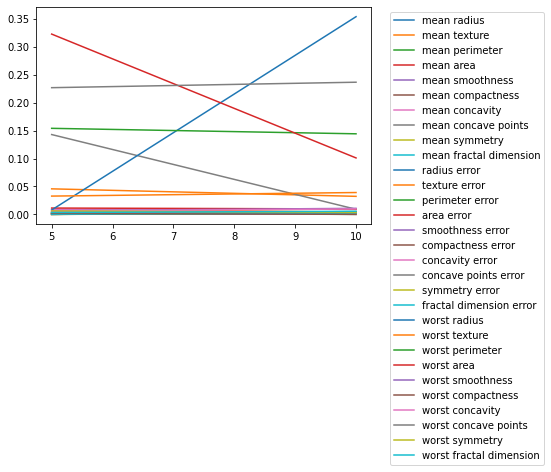

,Feature,Importance
20,worst radius,0.354073
27,worst concave points,0.236688
22,worst perimeter,0.144280
23,worst area,0.101052
21,worst texture,0.039100
1,mean texture,0.032267
24,worst smoothness,0.010780
11,texture error,0.009817
26,worst concavity,0.009755
13,area error,0.009710


In [ ]:
def calc_feature_importances(X, y, n_splits, seed):
    kf = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)
    dt = tree.DecisionTreeClassifier()
    feat_imps = []

    for train_idx, test_idx in kf.split(X, y):
        dt.fit(X[train_idx], y[train_idx])
        feat_imps.append(dt.feature_importances_)

    feat_imps_avg = np.mean(feat_imps, axis=0)
    
    return feat_imps_avg


seed = 3012

feat_imps_avg = []

for n_splits in range(5, 15, 5):
    feat_imps_avg.append(calc_feature_importances(X, y, n_splits, seed))

feat_imps_avg = np.array(feat_imps_avg)

for i in range(30):
    plt.plot(np.arange(5, 15, 5), feat_imps_avg[:,i], label=wisconsin.feature_names[i])

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

importances = pd.DataFrame(zip(wisconsin.feature_names, feat_imps_avg[-1,:]), columns=['Feature', 'Importance'])
# importances.to_csv("strat_kf_n_splits=10.csv", float_format="%.10f")
importances.sort_values(by = 'Importance', ascending = False).head(30)

## Randomness in decision trees

The specific splitting in a training and testing dataset has an influence on the feature importances of the tree. Also, on a given training set, every time a tree is trained, it can give different values, because of the random choosing. So, maybe k-fold cross validation is a good option here.

In [ ]:
seed = 421
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, stratify=y)

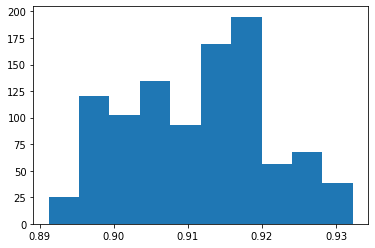

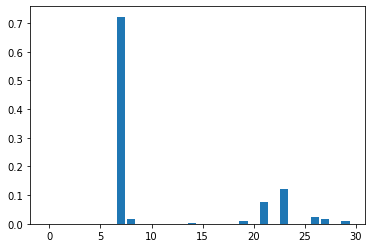

[0.         0.         0.         0.         0.         0.
 0.         0.72233872 0.0164203  0.         0.         0.
 0.         0.         0.00121234 0.         0.         0.
 0.         0.00950649 0.         0.07662054 0.         0.12285883
 0.         0.         0.02365305 0.01770816 0.         0.00968157]


In [ ]:
dt = tree.DecisionTreeClassifier()
feat_imps = []
bal_accs = []

for i in range(1000):
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    bal_acc = metrics.balanced_accuracy_score(y_test, y_pred)
    bal_accs.append(bal_acc)
    
plt.hist(bal_accs)
plt.show()

feat_imps.append(dt.feature_importances_)
feat_imps = np.array(feat_imps)
feat_imps_avg = np.mean(feat_imps, axis=0)

plt.bar(np.arange(30), feat_imps_avg)
plt.show()

print(feat_imps_avg)

# 0 = malignant, 1 = benign

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5161fece-8ef6-4825-9ea6-16ebba884483' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>